# MNIST From Scratch

This is my version of a simple 2 layer network to clasify MNIST. 
I used this video: https://youtu.be/JRlyw6LO5qo by George Hotz as a reference any many of the references within for futher reading.

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# import torchvision.datasets as datasets
import torch.optim as optim
# from torch.utils.data import DataLoader
from tqdm import trange

In [3]:
import gzip
import os
from urllib.request import urlretrieve


def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

#         return _onehot(integer_labels)
        return integer_labels

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [4]:
X_train, Y_train, X_test, Y_test = mnist()

# NN Using Torch

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784,128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128,10)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x


In [47]:
# train
model = SimpleNet()
BS=32
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
 
for i in (t := trange(500)):
    sample = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[sample])
    Y = torch.tensor(Y_train[sample])
    optimizer.zero_grad() # zero them out as they are saved evengr  over the epoch 
    guess = model(X)
    category = torch.argmax(guess, axis=1)
    accuracy = (category == Y).float().mean()
    accuracies.append(accuracy.item())
    loss = loss_function(guess, Y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    t.set_description(f'Loss: {loss.item():.3f}; Accuracy {accuracy:.5f}') # cool use of the assignment (:=) opertor 

Loss: 0.174; Accuracy 0.96875: 100%|██████████| 500/500 [00:03<00:00, 161.61it/s]


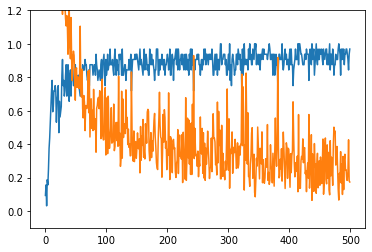

In [48]:
fig, ax = plt.subplots()
ax.plot(accuracies, label='acc')
ax.plot(losses, label='loss')
plt.ylim(-0.1,1.2);

In [9]:
# test
Y_preds = torch.argmax(model(torch.tensor(X_test)).float(),axis=1).numpy()
(Y_preds == Y_test).mean()

0.9205

# Numpy

In [10]:
#load layers in numpy and predict 
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128,10), dtype=np.float32)

In [11]:
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

In [12]:
# numpy forward pass 
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x,0)
    x = x.dot(l2)
    return x

In [13]:
# prediction from numpy
Y_test_preds_out = forward(X_test)
Y_test_preds = np.argmax(Y_test_preds_out,axis=1)
(Y_test_preds == Y_test).mean()

0.9195

In [14]:
Y_test_preds_out.shape

(10000, 10)

In [15]:
# cross entropy loss with no weightings is: log softamx loss on class x = - ln(e^x/sum over all the calsses e^x_i) = -x + ln(sum over all the classes e^x_i)

In [16]:
example_loss = -Y_test_preds_out[0,7] + np.log(np.exp(Y_test_preds_out[0]).sum())
# example_loss

In [17]:
# loss for each prediction, in each image (10000,).  sum(ax=1) sums over the 10 'probabilities'
losses = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

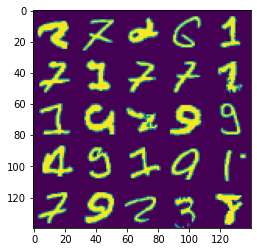

In [18]:
p=5
grid = sorted([(loss, i) for i,loss in enumerate(losses)], key=lambda x: x[0], reverse=True)[:p*p] # sort on loss and take the worst p^^2
X_bad = X_test[[t[1] for t in grid]]
stack = X_bad.reshape(p*p,28,28).reshape(p,p*28,28)
final_grid = np.concatenate(stack, axis= 1)
plt.imshow(final_grid)

# Backprop

local gradients of the network 

l2  \
rate of change of the output of l2 wrt to the output of the relu  \
dx_relu = l2  \
rate of change of the output of l2 wrt to the weights  \
d_l2 = x_relu 

relu  \
dx_l1 = (x_relu > 0).astype(np.float32) (gradient is one or zero)

l1  \
rate of change of the output of l2 wrt to the output of the relu  \
dx = l1  \
rate of change of the output of l2 wrt to the weights  \
d_l1 = x 

now use the chain rule


In [19]:
# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x
  
def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

In [20]:
def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forwards_backwards(x, y):
    # one hot encode the target vector
    out = np.zeros((len(y),10), np.float32) 
    out[range(out.shape[0]), y] = 1 
    
    #forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1,0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
    x_loss = (-out * x_lsm).mean(axis=1) 
    
    # backward pass via teh chain rule
    #https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative
    
    # dlsm/dxoutl2 lsm= log soft max
    d_out = -out / len(y) # doing a batch so keep d_out the same magnitude for any batch size
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1,1)) 
    # change the traget proabbility guess one way and the other 9 the other way
    # essentially just take away amounts from the wrong categories and add to the wright category
#     print(dx_lsm)
#     print(d_out)
#     print(np.exp(x_lsm)*d_out.sum(axis=1, keepdims=True))

    #top layer
    d_l2 = x_relu.T.dot(dx_lsm)
    d_xrelu = dx_lsm.dot(l2.T)

    #work back
    d_xl1 = (x_relu > 0).astype(np.float32)*d_xrelu

    #and again...
#     d_x = d_xl1.dot(l1.T) dont need a derivative wrt to the input onl the weights 
    d_l1 = x.T.dot(d_xl1)
    
    return d_l1, d_l2, x_l2, x_loss # return the learnable parameters in the model and the loss 
# testing
# sample = [56,78,98]
# forwards_backwards(X_test[sample], Y_test[sample])

In [112]:
# how to initialize the layers to stop gradients exploding or vanising 
# https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
#have difficulties converging when the weights are initilised with a normal distribution as differnt layers 
#can have different variances

# kaiming seems to be the go to and works well with a non symertric non linearity ie ReLU

def kaiming(m,h):

    ret = np.random.normal(loc=0.0, scale=np.sqrt(2/m), size=(m,h))

    return ret.astype(np.float32)

In [113]:
# full thing in numpy:

#instantiate a np network 

l1 = kaiming(784,128)
l2 = kaiming(128,10)
lr = 0.01
BS_np = 128
losses, accuracies = [], []
 
for i in (t := trange(1000)): # cool walrus operator as in C 
    # grab a minibatch 
    samples = np.random.randint(0, X_train.shape[0], size=BS_np)
    X = X_train[samples]
    Y = Y_train[samples]
    d_l1 , d_l2, x_l2, x_loss = forwards_backwards(X, Y)
    
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
    
    loss = x_loss.mean()
#     print(loss)
    predicted_category = np.argmax(x_l2, axis=1)
    acc = (predicted_category == Y).mean()
    losses.append(loss)
    accuracies.append(acc)

    t.set_description(f'Loss: {loss.item():.3f}; Accuracy {acc:.5f}') # cool use of the assignment (:=) opertor 

Loss: 0.041; Accuracy 0.89844: 100%|██████████| 1000/1000 [00:16<00:00, 60.90it/s]


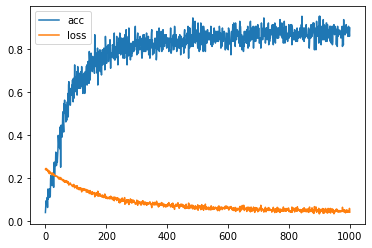

In [114]:
fig, ax = plt.subplots()
ax.plot(accuracies, label='acc')
ax.plot(losses, label='loss')
ax.legend()
# plt.ylim(-0.1,1.2);

In [115]:
numpy_eval()

0.8836